In [1]:
import numpy as np
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import datetime

In [2]:
print('Kernel printing here!')

Kernel printing here!


In [3]:
def vec_to_dict(vector):
    x_val, y_val, z_val = vector
    rho = np.sqrt(x_val ** 2 + y_val ** 2 + z_val ** 2)
    if rho == 0:
        theta = 0
    else:
        theta = np.arccos(z_val/rho) * 360/(2 * np.pi)
    if x_val == 0 and y_val == 0:
        phi = 0
    else:
        phi = np.arctan2(y_val, x_val) * 360/(2 * np.pi)
    if phi < 0:
        phi += 360

    move_dict =  {'rho':rho, 'theta':theta, 'phi': phi}
    return move_dict

###### Reference:
Nature Nanotechnology volume 11, pages677–681 (2016): https://www.nature.com/articles/nnano.2016.63#Sec5

https://static-content.springer.com/esm/art%3A10.1038%2Fnnano.2016.63/MediaObjects/41565_2016_BFnnano201663_MOESM10_ESM.pdf 

### Define paramters and sweep vectors

In [4]:
#FIRST SET MAGNET TO AN ESTIMATED B_NV

# DEFINING MEASUREMENT PARAMETERS
alpha_sweep_steps = 10
b_perp_mag = 2e-3 # in Tesla

aps_magnet.check_precision = 0.00001
magnetlogic._checktime = 1.5

#ODMR PARAMETERS DEFINED IN ODMR MODULE
freq_start, freq_stop, freq_step = (odmrlogic.mw_starts[0], odmrlogic.mw_stops[0], odmrlogic.mw_steps[0])
power = odmrlogic.sweep_mw_power 
channel = 0

runtime = odmrlogic.run_time #in s

# DEFINING MAGNETIC FIELD VECTORS
curr_pos_dict = magnetlogic.get_pos() #get current position
print('Current position', curr_pos_dict)
theta = np.deg2rad(curr_pos_dict['theta'])
phi = np.deg2rad(curr_pos_dict['phi'])
rho = curr_pos_dict['rho']
b_init = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]) * rho
b_init_params = (rho, theta, phi, b_init)

alphas = np.linspace(0, 360, alpha_sweep_steps)
b_perps = []
for a in alphas:
    b_perps.append(b_alpha(b_init_params, a, b_perp_mag)) #define alpha sweep B vectors - b_alpha function below

Current position {'rho': 0.19996059611833528, 'theta': 56.1438467954383, 'phi': 176.8239977649185}


### Run measurement loop

In [5]:
xy_data = np.zeros((len(b_perps), odmrlogic.odmr_plot_x.size))
afm_scanner_logic.run_IQ_DC()
odmrlogic.stop_jupyter_meas = False
for i, B in tqdm(enumerate(b_perps)):
    move_dict_abs = {'rho':B[0],'theta':B[1],'phi':B[2]}
    
    check_start_time = time.time()
    magnetlogic._magnet_device.move_abs(move_dict_abs)
    
    check_counter = 7
    while check_counter>0:
        while magnetlogic._check_is_moving():
            if (time.time()-check_start_time)>60:
                print('Magnet check time out!')
                break
            time.sleep(magnetlogic._checktime)
        check_counter-=1
    
    x_axis, data, fit_params = odmrlogic.perform_odmr_measurement([freq_start], [freq_step], [freq_stop], power, channel, runtime,
                                                                  fit_function='No Fit', save_after_meas=False, name_tag='')
    xy_data[i] = data
    xy_plot_matrix = xy_data.reshape((len(b_perps),1,odmrlogic.odmr_plot_x.size))
    y_axis = data.reshape((1, odmrlogic.odmr_plot_x.size))
    odmrlogic.sigOdmrPlotsUpdated.emit(odmrlogic.odmr_plot_x, y_axis, xy_plot_matrix)
    if odmrlogic.stop_jupyter_meas:
        print('Measurement force stopped!')
        break
odmrlogic.odmr_plot_y = y_axis
odmrlogic.odmr_plot_xy = xy_plot_matrix

10it [06:17, 37.78s/it]


### Determine theta<sub>0</sub>

delta ESR: 27.29957923884106 MHz


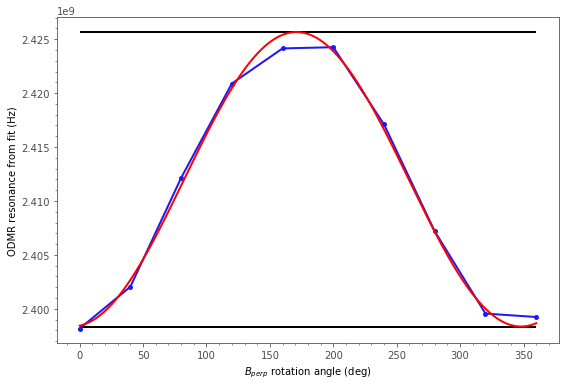

Theta_0: 14.107752707645083 deg
Alpha for max: 170.94509450945094 deg


In [7]:
alphas = np.linspace(0, 360, alpha_sweep_steps)
data = xy_data
fit_x = x_axis
fit_resonances = np.zeros(len(alphas))

#######################################
gslac_or_right_peak = True
#######################################

######################
ignore = []
######################
for idx, i in enumerate(alphas):
    fit_y = xy_data[idx]
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(fit_x,fit_y,
                                                estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    fit_resonances[idx] = fit.params['center'].value

alphas =  np.delete(alphas, ignore)
fit_resonances =  np.delete(fit_resonances, ignore)

plt.plot(alphas, fit_resonances)
fit = afm_scanner_logic._fitlogic.make_sine_fit(alphas,fit_resonances,
                                                          estimator=afm_scanner_logic._fitlogic.estimate_sine)
lm,_ = fitlogic.make_sine_model()
x_alphas = np.linspace(alphas[0],alphas[-1],10000, endpoint=True)
yeval = lm.eval(fit.params, x=x_alphas)
plt.plot(x_alphas, yeval,'r-')

alpha_max_freq = np.max(yeval)
alpha_min_freq = np.min(yeval)
alpha_max = x_alphas[np.argmax(yeval)]
alpha_min = x_alphas[np.argmin(yeval)]

#no fit data of sinusoid used
# alpha_max_freq = np.max(fit_resonances)
# alpha_min_freq = np.min(fit_resonances)
# alpha_max = alphas[np.argmax(fit_resonances)]
# alpha_min = alphas[np.argmin(fit_resonances)]
# print(f'Maximum: {alpha_max_freq/1e9} GHz \nMinimum: {alpha_min_freq/1e9} GHz')

delta_nu = alpha_max_freq - alpha_min_freq
print(f'delta ESR: {delta_nu/1e6} MHz')
plt.hlines(alpha_max_freq, alphas[0],alphas[-1])
plt.hlines(alpha_min_freq, alphas[0],alphas[-1])
plt.xlabel('$B_{perp}$ rotation angle (deg)')
plt.ylabel("ODMR resonance from fit (Hz)")
plt.show()

gyro_nv = 28e9
theta_0 = np.arcsin(delta_nu/(2*gyro_nv*b_perp_mag))
# print(f'Theta_0: {theta_0} rad')
print(f'Theta_0: {np.rad2deg(theta_0)} deg')
print(f'Alpha for max: {alpha_max} deg')
#determin the b_perp that would have given the alpha with maximum ESR shift - must assume fit is good - 
#used for calculating NV axis

b_perp_max = b_alpha(b_init_params, alpha_max if gslac_or_right_peak else alpha_min, b_perp_mag)[-1]                                                                        

### Determining NV axis

In [8]:
#find the vector, which is perpendicular to the plane of b_perp_rotated and b_init - 
#this is assuming that this particular alpha is the alpha that gave an extrema

rot_axis = np.cross(b_perp_max,b_init)
print(rot_axis, b_perp_max)

M1 = M(rot_axis, theta_0)
b_new = dot(M1,b_init)

[-5.68914409e-05 -3.92388077e-04 -5.22677790e-05] [ 0.00108121 -0.00037524  0.00164018]


### Move to B<sub>estimate</sub>

In [34]:
# move_dict = vec_to_dict(b_new)
move_dict = vec_to_dict(b_init)

print(move_dict)

{'rho': 0.19996059611833528, 'theta': 56.1438467954383, 'phi': 176.8239977649185}


In [35]:
magnetlogic.move_abs(move_dict)

{'rho': 0.19996059611833528, 'theta': 56.1438467954383, 'phi': 176.8239977649185}

In [12]:
alpha_b_init = b_init.copy()
alpha_b_perp_max = b_perp_max.copy()
alpha_rot_axis = rot_axis.copy()
alpha_theta0 = theta_0.copy()

# For bad b_perp values - doing a sweep in the b_init - b_nv plane (or ortho)

In [13]:
# Use this rotation axis ONLY after the inital alpha sweep
rot_axis = alpha_rot_axis.copy()

In [53]:
# Note the 1st plane values when happy
theta0_b_init = b_init.copy()
theta0_rot_axis = rot_axis.copy()
theta0_b_opti = b_opti.copy()

In [65]:
# Note the 2nd plane values when happy
theta0_orth_b_init = b_init.copy()
theta0_orth_rot_axis = rot_axis.copy()
theta0_orth_b_opti = b_opti.copy()

In [54]:
# Use this to CHANGE the rotation axis to the orthogonal plane
rot_axis = np.cross(rot_axis,b_opti)

*Note of sequence so far*

Example: Alpha - Theta - Theta - Theta_Ortho - Theta_Ortho

Current: Alpha1x - Theta3x - Redo - Theta2x - Theta_ortho2x

In [60]:
#STEPS
# Define b_init - current magnet position - either the start from last alignment step of alpha - or from one of theta steps
# ensure odmr steps are good
# ensure start, stop, step of thetas is good

aps_magnet.check_precision = 0.00001
magnetlogic._checktime = 1.5

#ODMR PARAMETERS DEFINED IN ODMR MODULE
freq_start, freq_stop, freq_step = (odmrlogic.mw_starts[0], odmrlogic.mw_stops[0], odmrlogic.mw_steps[0])
power = odmrlogic.sweep_mw_power 
channel = 0

runtime = odmrlogic.run_time #in s

# DEFINING MAGNETIC FIELD VECTORS
curr_pos_dict = magnetlogic.get_pos() #get current position
print('Current position', curr_pos_dict)
theta = np.deg2rad(curr_pos_dict['theta'])
phi = np.deg2rad(curr_pos_dict['phi'])
rho = curr_pos_dict['rho']
b_init = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]) * rho
b_init_params = (rho, theta, phi, b_init)

# obtaining different b vectors for a range of theta0 values. 
# Assuming here that the b_init was already good to start to with.

start = -0.5
stop = 0.5
step = 7

thetas = np.deg2rad(np.linspace(start,stop,step))
b_sweep_arr = []

for theta_0 in thetas:
    M1 = M(rot_axis, theta_0)
    b_new = dot(M1,b_init)
    x_val, y_val, z_val = b_new
    rho = np.sqrt(x_val ** 2 + y_val ** 2 + z_val ** 2)
    if rho == 0:
        theta = 0
    else:
        theta = np.arccos(z_val/rho) * 360/(2 * np.pi)
    if x_val == 0 and y_val == 0:
        phi = 0
    else:
        phi = np.arctan2(y_val, x_val) * 360/(2 * np.pi)
    if phi < 0:
        phi += 360

    move_dict =  {'rho':rho, 'theta':theta, 'phi': phi}
    b_sweep_arr.append(move_dict)

Current position {'rho': 0.19978303231255648, 'theta': 59.864635437716345, 'phi': 177.3793686447483}


### Run the theta0 sweep measurement loop

In [61]:
xy_data_plane_sweep = np.zeros((len(b_sweep_arr), odmrlogic.odmr_plot_x.size))

afm_scanner_logic.run_IQ_DC()
odmrlogic.stop_jupyter_meas = False
for i, B in tqdm(enumerate(b_sweep_arr)):
    move_dict_abs = {'rho':B['rho'],'theta':B['theta'],'phi':B['phi']}
    
    check_start_time = time.time()
    magnetlogic._magnet_device.move_abs(move_dict_abs)
    
    check_counter = 7
    while check_counter>0:
        while magnetlogic._check_is_moving():
            if (time.time()-check_start_time)>60:
                print('Magnet check time out!')
                break
            time.sleep(magnetlogic._checktime)
        check_counter-=1
    
    x_axis, data, fit_params = odmrlogic.perform_odmr_measurement([freq_start], [freq_step], [freq_stop], power, channel, runtime,
                                                                  fit_function='No Fit', save_after_meas=False, name_tag='')
    xy_data_plane_sweep[i] = data
    xy_plot_matrix = xy_data_plane_sweep.reshape((len(b_sweep_arr),1,odmrlogic.odmr_plot_x.size))
    y_axis = data.reshape((1, odmrlogic.odmr_plot_x.size))
    odmrlogic.sigOdmrPlotsUpdated.emit(odmrlogic.odmr_plot_x, y_axis, xy_plot_matrix)
    if odmrlogic.stop_jupyter_meas:
        print('Measurement force stopped!')
        break
odmrlogic.odmr_plot_y = y_axis
odmrlogic.odmr_plot_xy = xy_plot_matrix

7it [04:17, 36.86s/it]


### Plotting the sweep over theta ODMRs

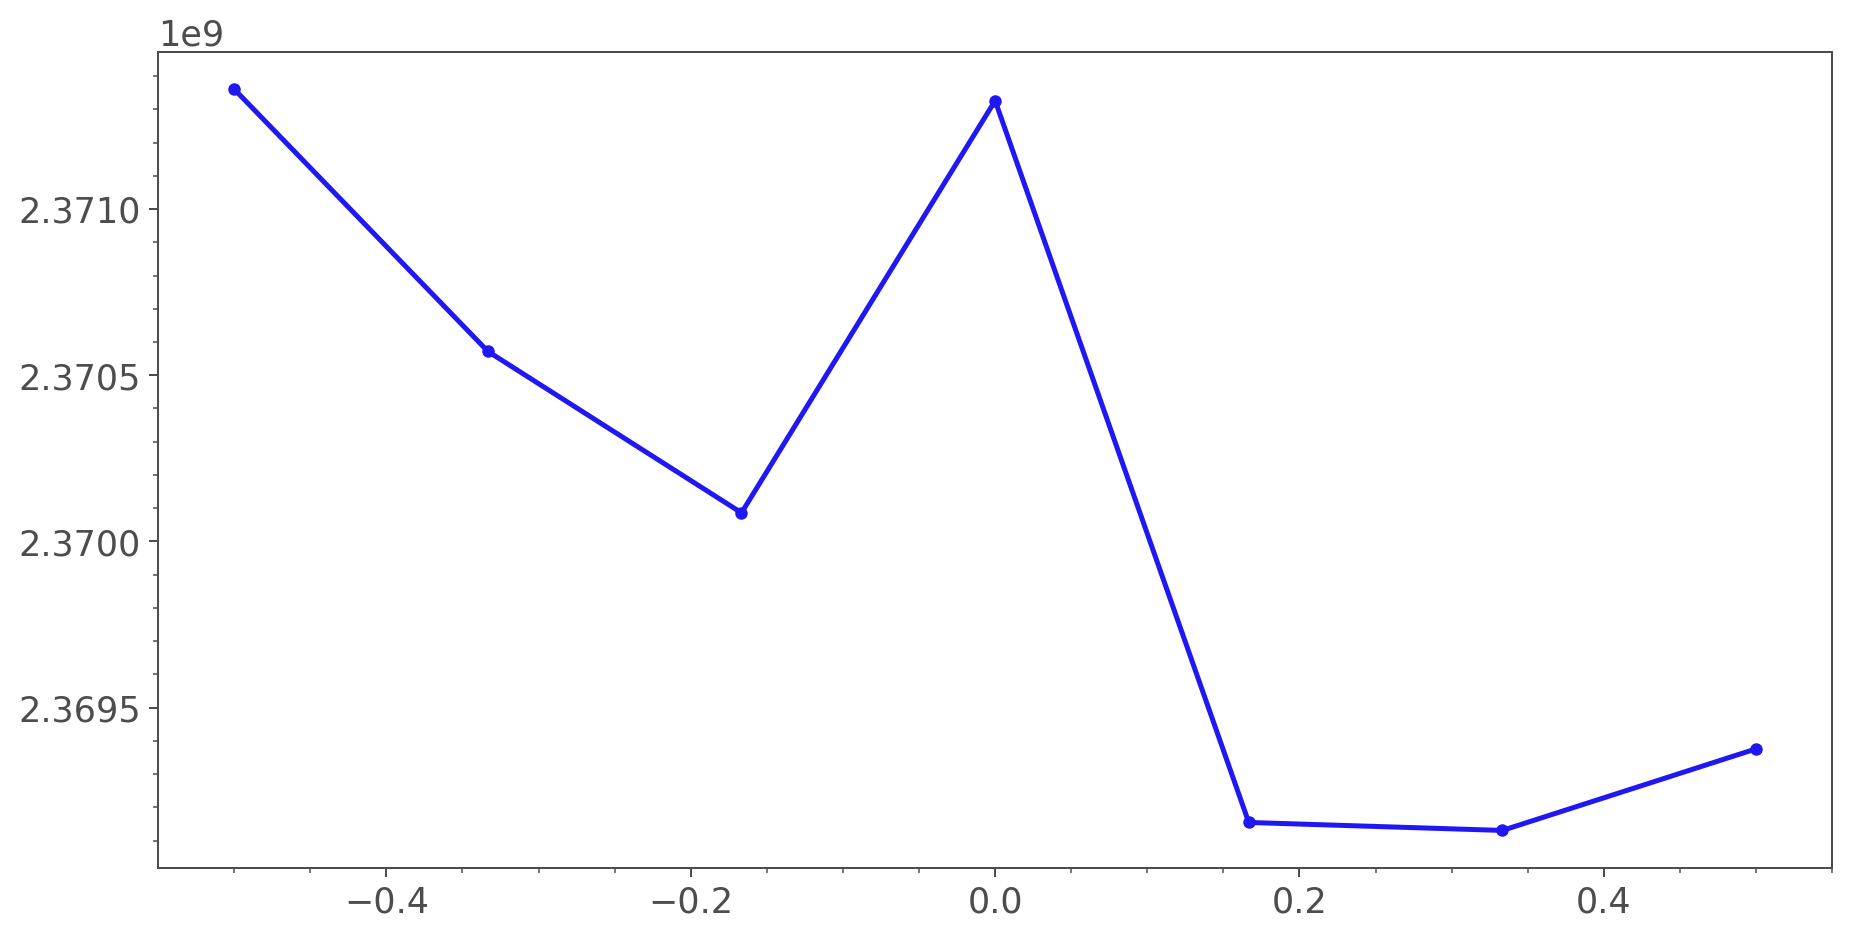

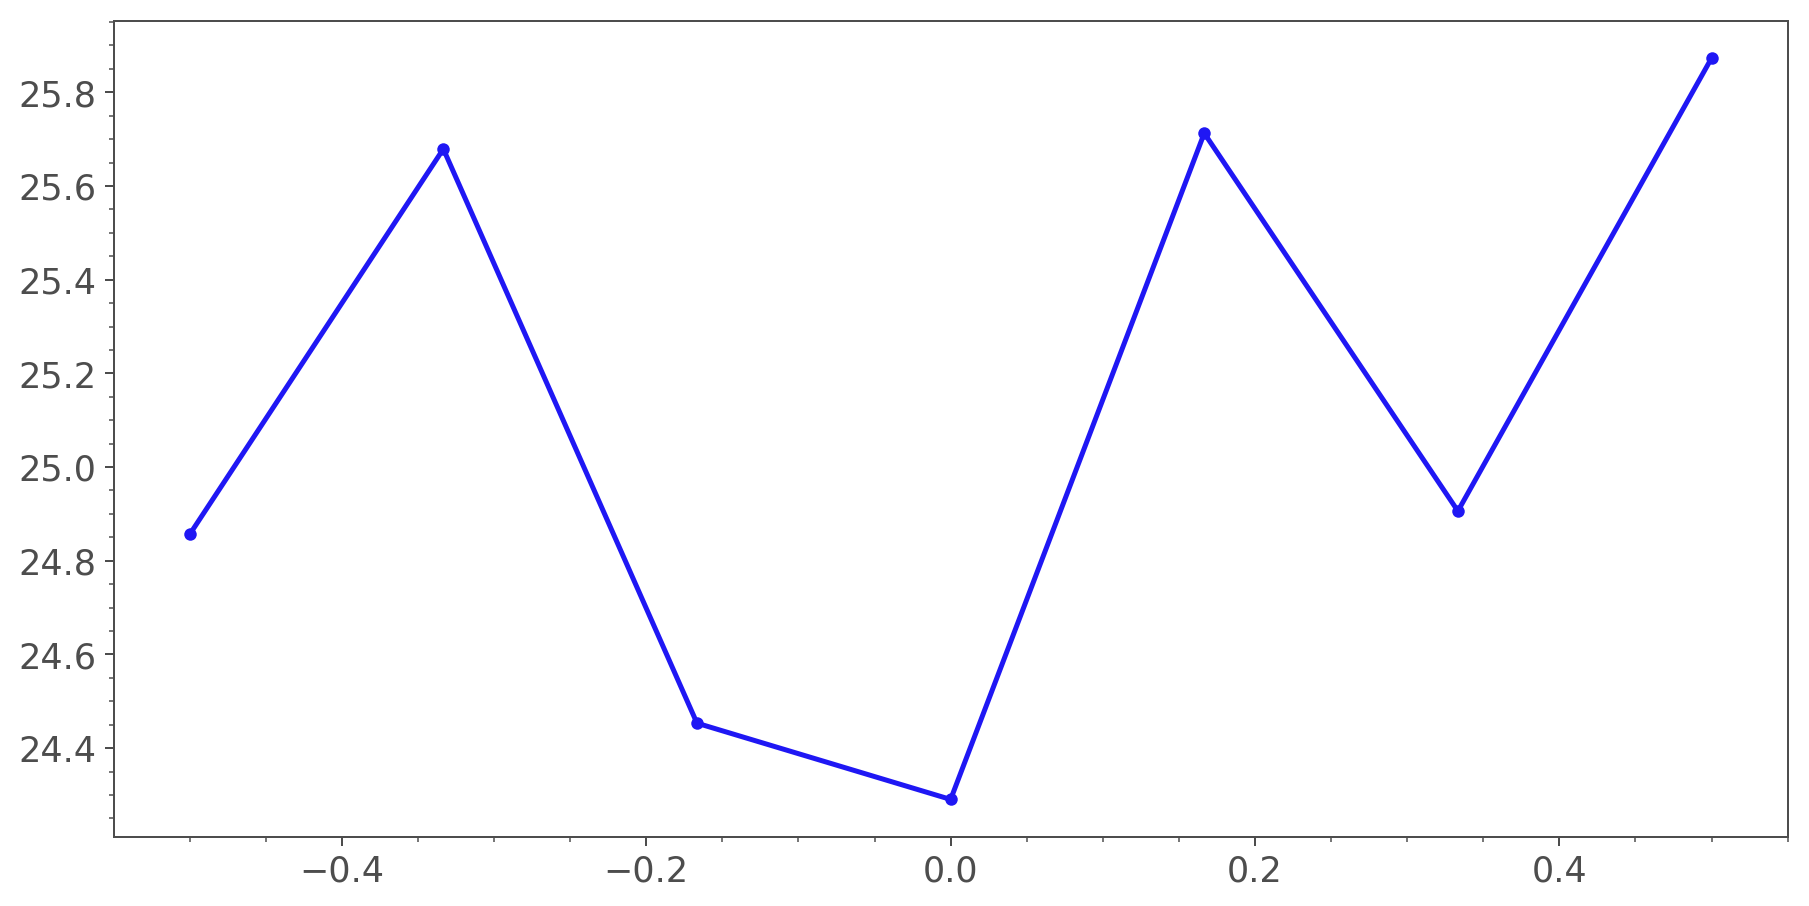

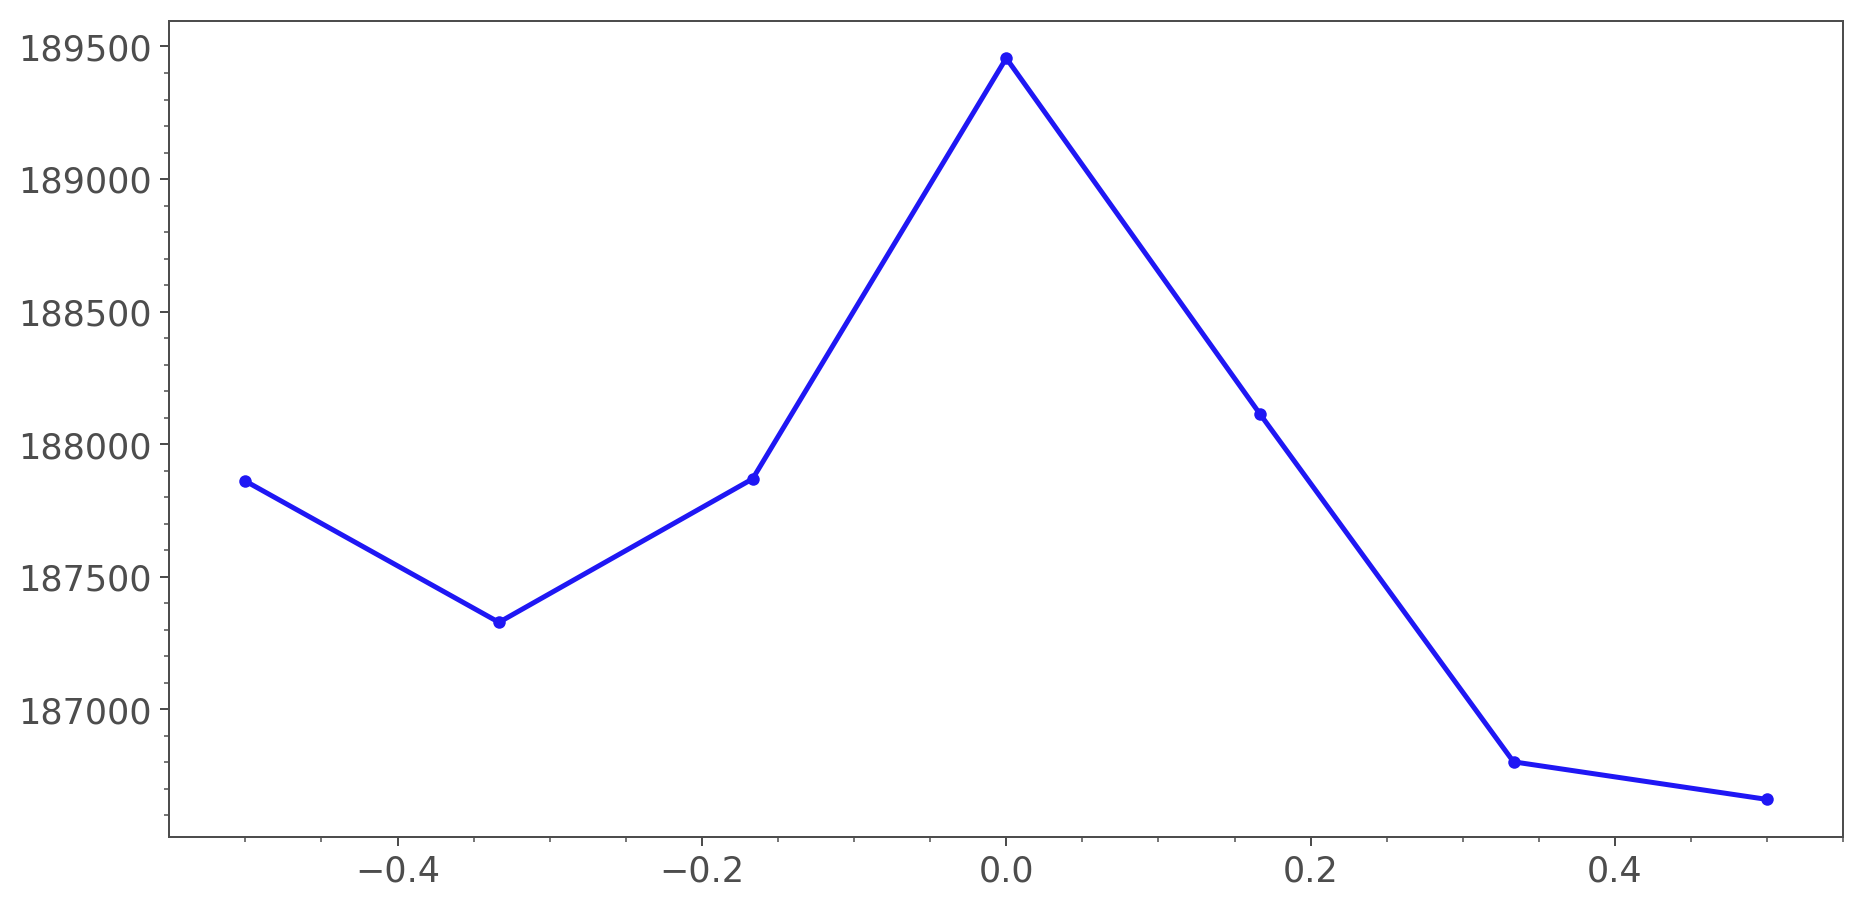

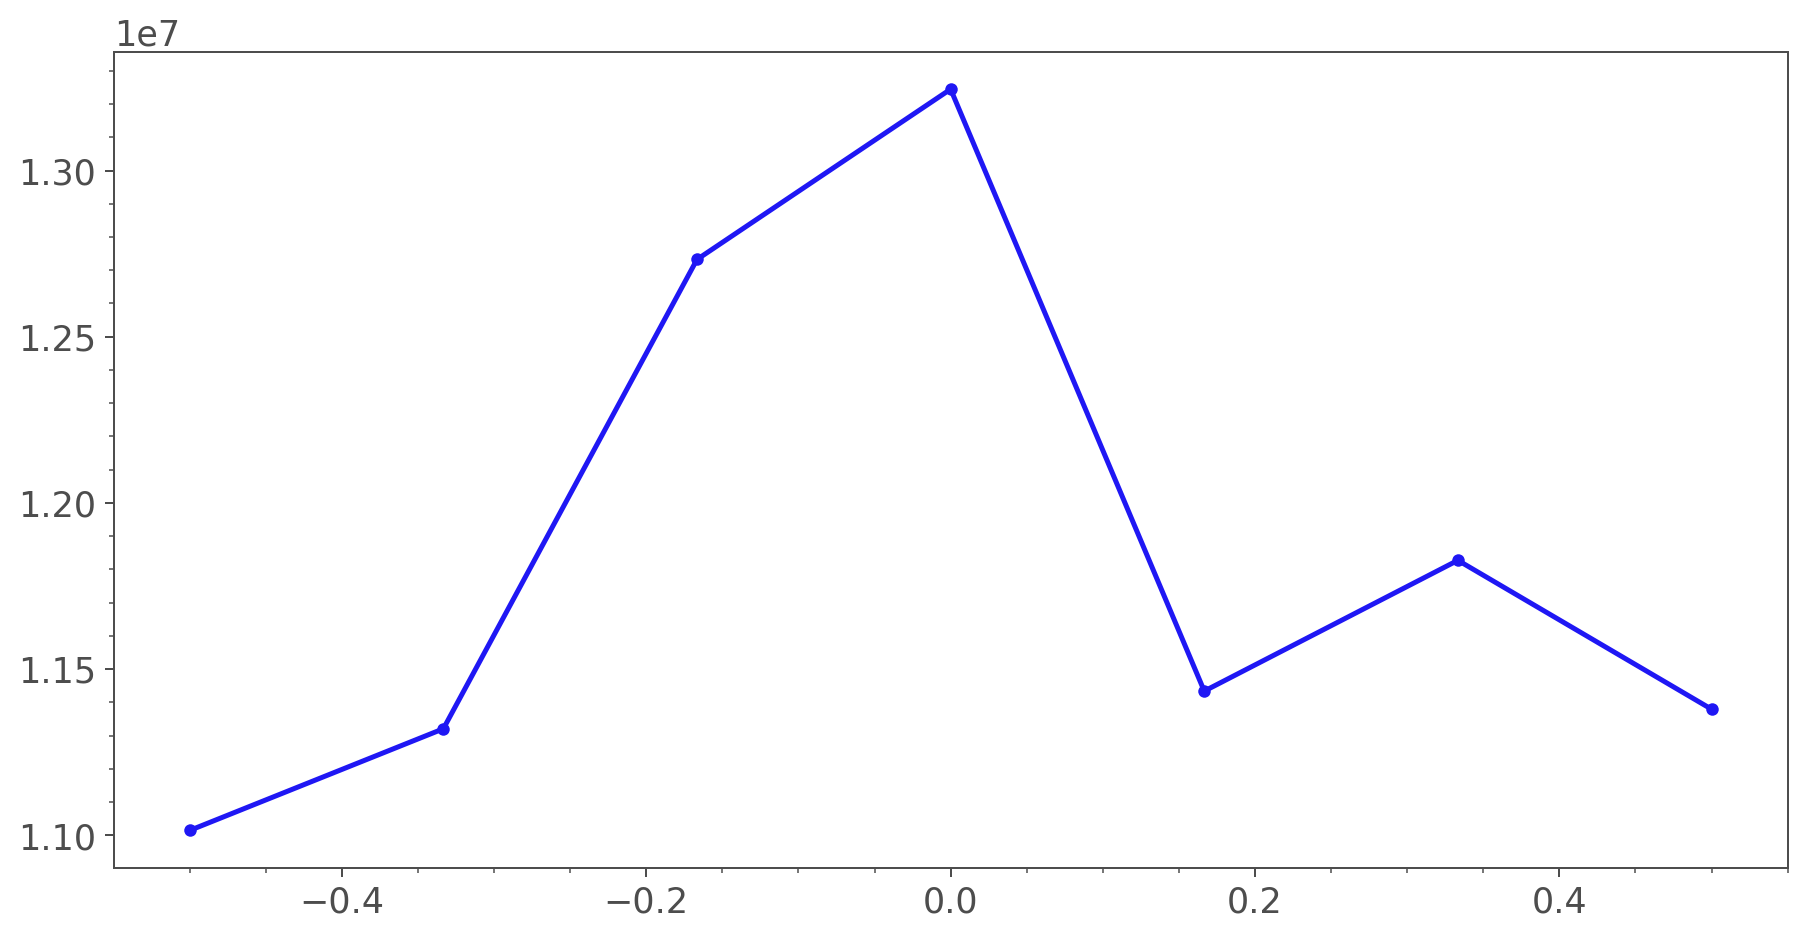

In [62]:
data = xy_data_plane_sweep
thetas = np.deg2rad(np.linspace(start,stop,step))
fit_x = x_axis

fit_resonances = []
param_n = 4
for i in range(param_n):
    fit_resonances.append(np.zeros(len(thetas)))

######################
ignore = []
######################
for idx, i in enumerate(thetas):
    fit_y = xy_data_plane_sweep[idx]
#     fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(fit_x,fit_y,
#                                                 estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    fit = afm_scanner_logic._fitlogic.make_gaussian_fit(fit_x,fit_y,
                                                estimator=afm_scanner_logic._fitlogic.estimate_gaussian_dip)
    fit_resonances[0][idx] = fit.params['center'].value
    fit_resonances[1][idx] = -fit.params['contrast'].value
    fit_resonances[2][idx] = fit.params['offset'].value
    fit_resonances[3][idx] = fit.params['fwhm'].value

thetas =  np.delete(thetas, ignore)
for idx in range(len(fit_resonances)):
    fit_resonances[idx] = np.delete(fit_resonances[idx], ignore)

for i in range(param_n):
    plt.plot(np.rad2deg(thetas), fit_resonances[i])
    plt.show()                         

In [63]:
# type in angle based on what you see in previous plots of theta vs ODMR parameter
to_go_angle = np.deg2rad(0.25)

M1 = M(rot_axis, to_go_angle)
b_opti = dot(M1,b_init)
move_dict =  vec_to_dict(b_opti)
print(move_dict)

{'rho': 0.19978303231255645, 'theta': 59.82447439112372, 'phi': 177.09399457759284}


In [64]:
magnetlogic.move_abs(move_dict)

{'rho': 0.19978303231255645, 'theta': 59.82447439112372, 'phi': 177.09399457759284}

### Helper functions below

##### b_alpha gives a new total B vector which is B<sub>init</sub> + B<sub>perp</sub>(alpha)

In [4]:
def M(axis, alpha_rot):
        return expm(cross(eye(3), axis/norm(axis)*alpha_rot))
    
def b_alpha(b_init_params, alpha, b_perp_mag):
    """ alpha is angle around the b_init in deg 
    returns total field = b_init + b_perp"""
    rho, theta, phi, b_init = b_init_params
    
    theta_perp = theta + np.pi/2
    b_perp = np.array([np.sin(theta_perp)*np.cos(phi), np.sin(theta_perp)*np.sin(phi), np.cos(theta_perp)]) * b_perp_mag
    
    alpha = np.deg2rad(alpha)
    M0 = M(b_init, alpha)
    b_perp_rotated = dot(M0,b_perp)
    
    b_total = b_init + b_perp_rotated
    
    x_val, y_val, z_val = b_total
    rho = np.sqrt(x_val ** 2 + y_val ** 2 + z_val ** 2)
    if rho == 0:
        theta = 0
    else:
        theta = np.arccos(z_val/rho) * 360/(2 * np.pi)
    if x_val == 0 and y_val == 0:
        phi = 0
    else:
        phi = np.arctan2(y_val, x_val) * 360/(2 * np.pi)
    if phi < 0:
        phi += 360
    return [rho, theta, phi, b_total, b_perp_rotated]

In [4]:
def plot_vectors(vectors):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    colors = ['r','b']
    for c, v1 in enumerate(vectors):
        ax.quiver(0, 0, 0, v1[0], v1[1], v1[2], arrow_length_ratio=0.1, color=colors[c])

    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_zlim([-1.1, 1.1])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Vector Plot')

    plt.show()

In [143]:
aps_magnet.ask_status()

{'x': '-0.066kG', 'y': '0.018kG', 'z': '0.072kG'}

In [14]:
# DEFINING MAGNETIC FIELD VECTORS
b_perp_mag = 1e-3
a = 0

#curr_pos_dict = magnetlogic.get_pos() #get current position
print('Current position', curr_pos_dict)
theta = np.deg2rad(curr_pos_dict['theta'])
phi = np.deg2rad(curr_pos_dict['phi'])
rho = curr_pos_dict['rho']
b_init = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]) * rho
b_init_params = (rho, theta, phi, b_init)

b_perp = b_alpha(b_init_params, a, b_perp_mag) #define alpha sweep B vectors - b_alpha function below
print('B_perp:',b_perp)

Current position {'rho': 0.19991673266637786, 'theta': 59.820591935636216, 'phi': 177.11441620107277}
B_perp: [0.19991675767678904, 59.8492517551372, 177.11441620107277, array([-0.17265021,  0.00870253,  0.10041355]), array([-5.02071889e-05,  2.53072157e-06, -8.64455530e-05])]
